Notebook for assessing stop/start and dfco impacts

In [3]:
import sys
import os
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import importlib
# import seaborn as sns
# sns.set(font_scale=2, style='whitegrid')

%matplotlib inline

In [4]:
# local modules
from fastsim import simdrive, cycle, vehicle

In [5]:
t0 = time.time()
cyc = cycle.Cycle("udds")
cyc_jit = cyc.get_numba_cyc()
print(time.time() - t0)

1.5458698272705078


In [6]:
t0 = time.time()
veh0 = vehicle.Vehicle(1).get_numba_veh()
print(time.time() - t0)

12.358967542648315


In [7]:
t0 = time.time()
veh1 = vehicle.Vehicle(28).get_numba_veh()
print(time.time() - t0)

0.0359039306640625


In [9]:
t0 = time.time()
sim_drive0 = simdrive.SimDriveJit(cyc_jit, veh0)
sim_drive0.sim_drive()
print(time.time() - t0)
sim_drive1 = simdrive.SimDriveJit(cyc_jit, veh1)
sim_drive1.sim_drive()
print(time.time() - t0)

62.620187520980835
62.62617063522339


(0.0, 35.0)

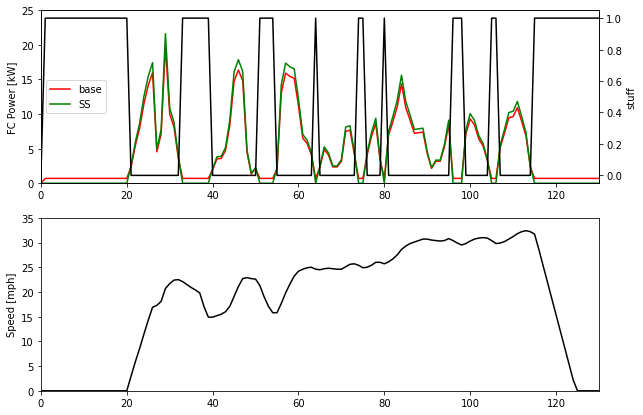

In [10]:
plt.figure(figsize=(10, 7))
ax0 = plt.subplot(211)
ax0.plot(cyc.cycSecs, sim_drive0.fcKwOutAch, label='base', color='red')
ax0.plot(cyc.cycSecs, sim_drive1.fcKwOutAch, label='SS', color='green')
# ax.plot(cyc.cycSecs, dfco_fcKwOutAchPos, label='dfco', linestyle='--', color='blue')
ax0.legend(loc='center left')
ax0.set_ylabel('FC Power [kW]')
ax0.set_ylim([0, 25])
ax0.set_xlim([0, 130])

ax1 = ax0.twinx()
ax1.plot(cyc.cycSecs, sim_drive1.canPowerAllElectrically, color='black')
ax1.set_ylabel('stuff')
ax1.set_xlim(ax0.get_xlim())
# ax1.set_ylim([0.52, 0.526])

ax2 = plt.subplot(212)
ax2.plot(cyc.cycSecs, cyc.cycMph, color='black')
ax2.set_ylabel('Speed [mph]')
ax2.set_xlim(ax0.get_xlim())
ax2.set_ylim([0, 35])

(0.0, 130.0)

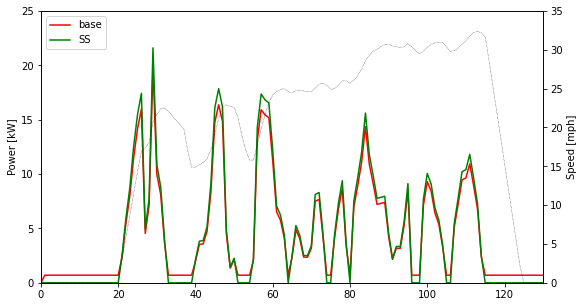

In [11]:
fig, ax = plt.subplots(figsize=(9, 5))

ax.plot(cyc.cycSecs, sim_drive0.fcKwOutAch, label='base', color='red')
ax.plot(cyc.cycSecs, sim_drive1.fcKwOutAch, label='SS', color='green')
# ax.plot(cyc.cycSecs, dfco_fcKwOutAchPos, label='dfco', linestyle='--', color='blue')
ax.legend(loc='upper left')
ax.set_ylabel('Power [kW]')
ax.set_ylim([0, 25])

ax2 = ax.twinx()
ax2.plot(cyc.cycSecs, cyc.cycMph, linestyle=':', linewidth=0.5, color='black')
ax2.set_ylabel('Speed [mph]')
ax2.set_ylim([0, 35])

plt.xlabel('Time [s]')

plt.xlim([0, 130])

(0.0, 130.0)

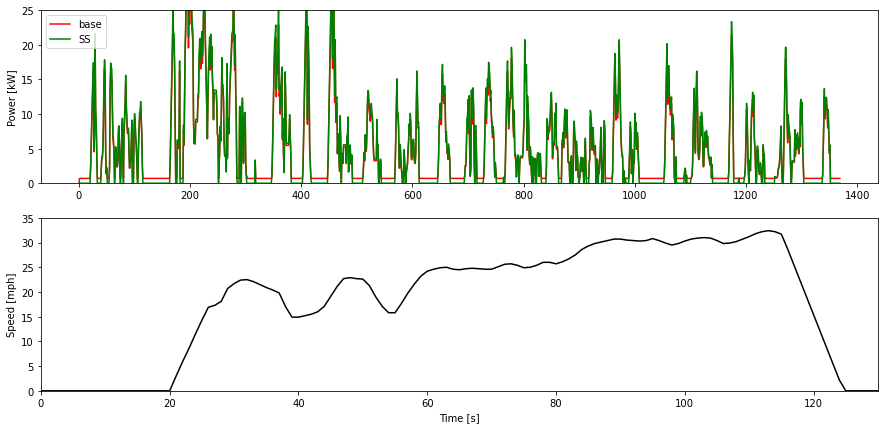

In [12]:
plt.figure(figsize=(15,7))
plt.subplot(211)
plt.plot(cyc.cycSecs, sim_drive0.fcKwOutAch, label='base', color='red')
plt.plot(cyc.cycSecs, sim_drive1.fcKwOutAch, label='SS', color='green')
# ax.plot(cyc.cycSecs, dfco_fcKwOutAchPos, label='dfco', linestyle='--', color='blue')
plt.legend(loc='upper left')
plt.ylabel('Power [kW]')
plt.ylim([0, 25])

plt.subplot(212)
# ax2 = ax.twinx()
plt.plot(cyc.cycSecs, cyc.cycMph, color='black')
plt.ylabel('Speed [mph]')
plt.ylim([0, 35])

plt.xlabel('Time [s]')

plt.xlim([0, 130])